In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
df = pd.read_json(
    "problems_data.jsonl",
    lines=True,
    encoding="utf-8-sig"
)


In [3]:
df

,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree
...,...,...,...,...,...,...,...,...
4107,Tölvunarfræðingar telja,Computer scientists count a bit different from...,Input consists of one line with one integer $n$.,"Output the $n$-th\n number, according to co...","[{'input': '1', 'output': '0'}, {'input': '2',...",easy,1.1,https://open.kattis.com/problems/tolvunarfraed...
4108,Velkomin!,Welcome to Forritunarkeppni Framhaldsskólanna ...,There is no input in this problem.,Print a single line containing VELKOMIN!,"[{'input': '', 'output': 'VELKOMIN!'}]",easy,1.1,https://open.kattis.com/problems/velkomin
4109,Til hamingju,,There is no input in this problem.,Print a single line containing TIL\n HAMING...,"[{'input': '', 'output': 'TIL HAMINGJU MED AFM...",easy,1.1,https://open.kattis.com/problems/tilhamingju
4110,Hipp Hipp,,There is no input in this problem.,Print 20 lines. Each line should contain Hipp ...,"[{'input': '', 'output': 'Hipp hipp hurra! Hip...",easy,1.1,https://open.kattis.com/problems/hipphipp


In [3]:
df["full_text"] = (
    "[TITLE] "  + df["title"].fillna("").astype(str) + " "
    "[DESC] "   + df["description"].fillna("").astype(str) + " "
    "[INPUT] "  + df["input_description"].fillna("").astype(str) + " "
    "[OUTPUT] " + df["output_description"].fillna("").astype(str) + " "
    "[SAMPLE] " + df["sample_io"].fillna("").astype(str)
)

In [4]:
X = df["full_text"]

y_class = df["problem_class"]   # classification target
y_score = df["problem_score"]   # regression target

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_class_train, y_class_test, y_score_train, y_score_test = train_test_split(X,y_class,y_score,test_size=0.2,random_state=42,stratify=y_class)


In [6]:
def text_length_features(text):
    return {
        "char_count": len(text),
        "word_count": len(text.split()),
        "sentence_count": text.count('.') + text.count('\n')
    }


In [7]:
def numeric_features(text):
    numbers = re.findall(r'\d+', text)
    numbers = [int(n) for n in numbers if len(n) < 10]  # avoid huge junk numbers

    return {
        "num_count": len(numbers),
        "max_number": max(numbers) if numbers else 0,
        "avg_number": np.mean(numbers) if numbers else 0
    }


In [8]:
KEYWORDS = [
    "dp", "dynamic programming", "graph", "tree", "bfs", "dfs",
    "recursion", "greedy", "bitmask", "segment tree",
    "mod", "prime", "math"
]

def keyword_features(text):
    text_lower = text.lower()
    features = {}
    for kw in KEYWORDS:
        features[f"kw_{kw.replace(' ', '_')}"] = text_lower.count(kw)
    return features


In [9]:
SYMBOLS = ["<=", ">=", "%", "^", "|", "&"]

def symbol_features(text):
    features = {}
    for sym in SYMBOLS:
        features[f"sym_{sym}"] = text.count(sym)
    return features


In [10]:
def extract_features(text):
    features = {}
    features.update(text_length_features(text))
    features.update(numeric_features(text))
    features.update(keyword_features(text))
    features.update(symbol_features(text))
    return features


In [11]:
X_train_feats = pd.DataFrame(
    X_train.apply(extract_features).tolist()
)

X_test_feats = pd.DataFrame(
    X_test.apply(extract_features).tolist()
)


In [12]:
X_train_feats.tail()


,char_count,word_count,sentence_count,num_count,max_number,avg_number,kw_dp,kw_dynamic_programming,kw_graph,kw_tree,...,kw_segment_tree,kw_mod,kw_prime,kw_math,sym_<=,sym_>=,sym_%,sym_^,sym_|,sym_&
3284,1562,266,36,22,130,7.590909,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3285,960,178,21,49,19,4.612245,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3286,1919,308,42,23,100,8.521739,0,0,0,0,...,0,1,0,0,0,0,0,4,0,0
3287,1422,201,26,6,1948,327.833333,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
3288,1411,231,33,24,100,19.541667,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [13]:
y_class_train.tail()

3868      easy
4040      easy
240       hard
639       hard
2073    medium
Name: problem_class, dtype: object

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_feats_scaled = scaler.fit_transform(X_train_feats)
X_test_feats_scaled = scaler.transform(X_test_feats)


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1, 2), max_features=10000)


In [16]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)


In [17]:
from scipy.sparse import hstack

X_train_final = hstack([X_train_tfidf, X_train_feats_scaled])
X_test_final = hstack([X_test_tfidf, X_test_feats_scaled])


In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_class_train)
y_test_enc  = le.transform(y_class_test)

print(le.classes_)  # ['Easy', 'Hard', 'Medium'] (order may vary)


['easy' 'hard' 'medium']


Random Forest Accuracy: 0.5164034021871203
F1score : 0.43111160678444155
------------------------------------------------------------
              precision    recall  f1-score   support

        easy       0.57      0.28      0.38       153
        hard       0.54      0.84      0.65       389
      medium       0.40      0.20      0.26       281

    accuracy                           0.52       823
   macro avg       0.50      0.44      0.43       823
weighted avg       0.50      0.52      0.47       823

------------------------------------------------------------


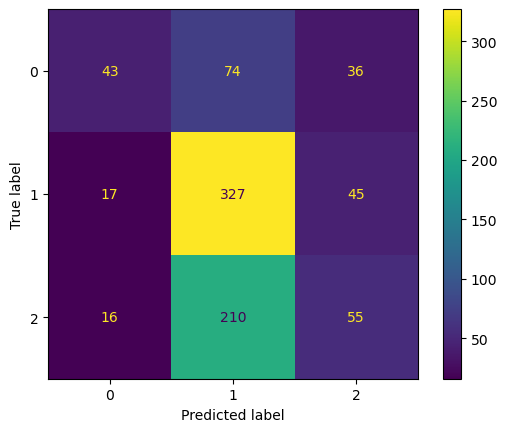

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
rf = RandomForestClassifier(random_state=18)

rf.fit(X_train_final, y_train_enc)

y_pred_rf = rf.predict(X_test_final)
acc_rf = accuracy_score(y_test_enc, y_pred_rf)
print("Random Forest Accuracy:", acc_rf)
print("F1score :", f1_score(y_test_enc,y_pred_rf,average="macro"))
print("--"*30)
print(classification_report(y_test_enc, y_pred_rf, target_names=le.classes_))
print("--"*30)
cm = confusion_matrix(y_test_enc, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= rf.classes_)
disp.plot()
plt.show()

Logistic Regression Accuracy: 0.5054678007290401
F1score : 0.45415537122552935
------------------------------------------------------------
              precision    recall  f1-score   support

        easy       0.53      0.34      0.41       153
        hard       0.54      0.74      0.63       389
      medium       0.39      0.27      0.32       281

    accuracy                           0.51       823
   macro avg       0.49      0.45      0.45       823
weighted avg       0.49      0.51      0.48       823

------------------------------------------------------------


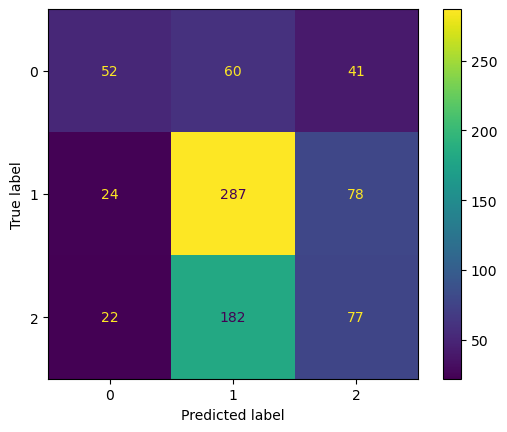

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logreg = LogisticRegression(max_iter=1000, n_jobs=-1)

logreg.fit(X_train_final, y_train_enc)
y_pred_lr = logreg.predict(X_test_final)
acc_lr = accuracy_score(y_test_enc, y_pred_lr)
print("Logistic Regression Accuracy:", acc_lr)
print("F1score :", f1_score(y_test_enc,y_pred_lr,average="macro"))

print("--"*30)

print(classification_report(y_test_enc, y_pred_lr, target_names=le.classes_))
print("--"*30)

cm = confusion_matrix(y_test_enc, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= logreg.classes_)
disp.plot()
plt.show()

XGBoost Accuracy: 0.5006075334143378
------------------------------------------------------------
              precision    recall  f1-score   support

        easy       0.49      0.37      0.42       153
        hard       0.56      0.71      0.62       389
      medium       0.37      0.28      0.32       281

    accuracy                           0.50       823
   macro avg       0.47      0.45      0.46       823
weighted avg       0.48      0.50      0.48       823

------------------------------------------------------------


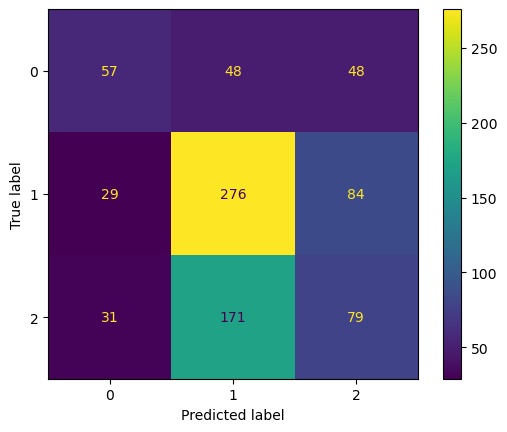

In [46]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=2000,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    device="cuda",
    random_state=18
)

xgb.fit(X_train_final, y_train_enc)
y_pred_xgb = xgb.predict(X_test_final)
acc_xgb = accuracy_score(y_test_enc, y_pred_xgb)
print("XGBoost Accuracy:", acc_xgb)
print("--"*30)
print(classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))
print("--"*30)
cm = confusion_matrix(y_test_enc, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= logreg.classes_)
disp.plot()
plt.show()


In [47]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ("lr", logreg),
        ("rf", rf),
        ("xgb", xgb)
    ],
    voting="soft",
    n_jobs=-1
)
voting_clf.fit(X_train_final, y_train_enc)
y_pred_vote = voting_clf.predict(X_test_final)

print("Voting Accuracy:", accuracy_score(y_test_enc, y_pred_vote))
print("Voting F1 (macro):", f1_score(y_test_enc, y_pred_vote, average="macro"))
print("--"*30)

print(classification_report(
    y_test_enc,
    y_pred_vote,
    target_names=le.classes_
))


Voting Accuracy: 0.5139732685297691
Voting F1 (macro): 0.4563678272632721
------------------------------------------------------------
              precision    recall  f1-score   support

        easy       0.54      0.34      0.42       153
        hard       0.55      0.77      0.64       389
      medium       0.38      0.26      0.31       281

    accuracy                           0.51       823
   macro avg       0.49      0.45      0.46       823
weighted avg       0.49      0.51      0.49       823



Lets tune these indvisual models for f1 score and then try softvoting ensemble

In [48]:
import optuna
from sklearn.linear_model import LogisticRegression

def objective_logreg(trial):
    C = trial.suggest_float("C", 0.01, 10, log=True)
    class_weight = trial.suggest_categorical(
        "class_weight", [None, "balanced"]
    )

    model = LogisticRegression(
        C=C,
        class_weight=class_weight,
        max_iter=300,
        n_jobs=-1,
        random_state=42
    )

    model.fit(X_train_final, y_train_enc)
    preds = model.predict(X_test_final)

    return f1_score(y_test_enc, preds, average="macro")

study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_logreg, n_trials=25)

print(study_lr.best_params)
print(study_lr.best_value)


[I 2026-01-04 09:34:38,880] A new study created in memory with name: no-name-feda540b-89dd-4b16-a8bd-42b243a02a03
[I 2026-01-04 09:34:41,752] Trial 0 finished with value: 0.46338724951941906 and parameters: {'C': 6.580688616922706, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.46338724951941906.
[I 2026-01-04 09:34:51,819] Trial 1 finished with value: 0.4527080561168515 and parameters: {'C': 8.317242055148384, 'class_weight': None}. Best is trial 0 with value: 0.46338724951941906.
[I 2026-01-04 09:34:58,003] Trial 2 finished with value: 0.47311433742908227 and parameters: {'C': 4.601394849460321, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.47311433742908227.
[I 2026-01-04 09:35:02,463] Trial 3 finished with value: 0.4107163559863032 and parameters: {'C': 0.18581171419103512, 'class_weight': None}. Best is trial 2 with value: 0.47311433742908227.
[I 2026-01-04 09:35:14,146] Trial 4 finished with value: 0.4218653152459341 and parameters: {'C': 0.10654720854073

{'C': 2.3864894191542154, 'class_weight': 'balanced'}
0.47967740957485683


In [50]:
from sklearn.ensemble import RandomForestClassifier

def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 200, 500)
    max_depth = trial.suggest_int("max_depth", 10, 40)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=18,
        n_jobs=-1
    )

    model.fit(X_train_final, y_train_enc)
    preds = model.predict(X_test_final)

    return f1_score(y_test_enc, preds, average="macro")

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=25)

print(study_rf.best_params)
print(study_rf.best_value)


[I 2026-01-04 09:38:31,160] A new study created in memory with name: no-name-8135d77b-f19e-4b38-8c89-9d309c86d858
[I 2026-01-04 09:38:32,436] Trial 0 finished with value: 0.3774176386331083 and parameters: {'n_estimators': 304, 'max_depth': 21, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.3774176386331083.
[I 2026-01-04 09:38:33,711] Trial 1 finished with value: 0.4087621947301137 and parameters: {'n_estimators': 329, 'max_depth': 40, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.4087621947301137.
[I 2026-01-04 09:38:35,125] Trial 2 finished with value: 0.38401536800413205 and parameters: {'n_estimators': 411, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.4087621947301137.
[I 2026-01-04 09:38:37,121] Trial 3 finished with value: 0.4062746509810046 and parameters: {'n_estimators': 486, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.4087621947301137.
[I 2026-01-04 09:38:38,496] Trial 4 finished with value: 0.40298954656283

{'n_estimators': 245, 'max_depth': 33, 'min_samples_leaf': 2}
0.4248332615266956


In [51]:
from xgboost import XGBClassifier

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "objective": "multi:softprob",
        "num_class": len(le.classes_),
        "eval_metric": "mlogloss",
        "random_state": 18,
        "n_jobs": -1
    }

    model = XGBClassifier(**params)

    model.fit(X_train_final, y_train_enc)
    preds = model.predict(X_test_final)

    return f1_score(y_test_enc, preds, average="macro")

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=20)

print(study_xgb.best_params)
print(study_xgb.best_value)


[I 2026-01-04 09:40:15,327] A new study created in memory with name: no-name-ea5edf27-b209-4730-97b5-8db67b876c00
[I 2026-01-04 09:40:53,246] Trial 0 finished with value: 0.4799473397476844 and parameters: {'n_estimators': 370, 'max_depth': 4, 'learning_rate': 0.0716427429372566, 'subsample': 0.9260292239235107, 'colsample_bytree': 0.6758570547915171}. Best is trial 0 with value: 0.4799473397476844.
[I 2026-01-04 09:41:51,510] Trial 1 finished with value: 0.4762824089363089 and parameters: {'n_estimators': 374, 'max_depth': 5, 'learning_rate': 0.03648825954299538, 'subsample': 0.6620024606012723, 'colsample_bytree': 0.8820575013344061}. Best is trial 0 with value: 0.4799473397476844.
[I 2026-01-04 09:44:49,521] Trial 2 finished with value: 0.47382935627683076 and parameters: {'n_estimators': 486, 'max_depth': 8, 'learning_rate': 0.023839523464037938, 'subsample': 0.791429107022169, 'colsample_bytree': 0.9110757894196129}. Best is trial 0 with value: 0.4799473397476844.
[I 2026-01-04 09

{'n_estimators': 310, 'max_depth': 6, 'learning_rate': 0.11313145928781458, 'subsample': 0.6054997208653785, 'colsample_bytree': 0.6006971737646392}
0.4900172813506502


In [52]:
best_lr = LogisticRegression(**study_lr.best_params,max_iter=300,n_jobs=-1,random_state=18)
best_lr.fit(X_train_final, y_train_enc)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,2.3864894191542154
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,18
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


In [53]:
best_rf = RandomForestClassifier(**study_rf.best_params, random_state=18)
best_rf.fit(X_train_final,y_train_enc)

,n_estimators,245
,criterion,'gini'
,max_depth,33
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [54]:
best_xgb = XGBClassifier(**study_xgb.best_params)
best_xgb.fit(X_train_final, y_train_enc)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6006971737646392
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ("lr", best_lr),
        ("rf", best_rf),
        ("xgb", best_xgb)
    ],
    voting="soft",
    weights=[1.5, 1.5, 1]
)

voting_clf.fit(X_train_final, y_train_enc)
y_pred_vote = voting_clf.predict(X_test_final)

print("Voting Accuracy:", accuracy_score(y_test_enc, y_pred_vote))
print("Voting F1 (macro):", f1_score(y_test_enc, y_pred_vote, average="macro"))
print("--"*30)

print(classification_report(
    y_test_enc,
    y_pred_vote,
    target_names=le.classes_
))


Voting Accuracy: 0.511543134872418
Voting F1 (macro): 0.4670775029389353
------------------------------------------------------------
              precision    recall  f1-score   support

        easy       0.52      0.42      0.46       153
        hard       0.56      0.74      0.63       389
      medium       0.38      0.25      0.30       281

    accuracy                           0.51       823
   macro avg       0.49      0.47      0.47       823
weighted avg       0.49      0.51      0.49       823



Lets similarly do regression now

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    random_state=42
)

rf_reg.fit(X_train_final, y_score_train)

y_pred = rf_reg.predict(X_test_final)
y_pred = np.clip(y_pred, 0, 10)

print("R2:", r2_score(y_score_test, y_pred))
print("RMSE:", root_mean_squared_error(y_score_test, y_pred))


R2: 0.1723048828070638
RMSE: 2.004139250146929


In [83]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
ridge.fit(X_train_final,y_score_train)
lasso.fit(X_train_final,y_score_train)
lr.fit(X_train_final,y_score_train)
lr_pred = lr.predict(X_test_final)
lr_pred = np.clip(lr_pred, 0, 10)
l_pred = lasso.predict(X_test_final)
l_pred = np.clip(l_pred, 0, 10)
r_pred = ridge.predict(X_test_final)
r_pred= np.clip(r_pred, 0,10)

print("LinearRegression")
print("R2:", r2_score(y_score_test, lr_pred))
print("RMSE:", root_mean_squared_error(y_score_test, lr_pred))
print("--"*30)
print("Lasso")
print("R2:", r2_score(y_score_test, l_pred))
print("RMSE:", root_mean_squared_error(y_score_test, l_pred))
print("--"*30)
print("Ridge")
print("R2:", r2_score(y_score_test, r_pred))
print("RMSE:", root_mean_squared_error(y_score_test, r_pred))
print("--"*30)

LinearRegression
R2: -3.955369636041133
RMSE: 4.90377713911251
------------------------------------------------------------
Lasso
R2: -0.000247450970462193
RMSE: 2.2031619560770292
------------------------------------------------------------
Ridge
R2: 0.1238055521738386
RMSE: 2.0620203424644403
------------------------------------------------------------


In [84]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=2000,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="rmse",
    device="cuda",
    random_state=42)
xgb.fit(X_train_final, y_score_train)
ypred_xgb = xgb.predict(X_test_final)
ypred_xgb= np.clip(ypred_xgb, 0,10)

rmse_xgb = root_mean_squared_error(y_score_test,ypred_xgb)
r2_xgb = r2_score(y_true=y_score_test, y_pred= ypred_xgb)
print("XGBoost")
print("RMSE: ", rmse_xgb)
print("R2 score: ",r2_xgb)

XGBoost
RMSE:  2.014122802272543
R2 score:  0.16403807288929562


In [85]:
from sklearn.ensemble import VotingRegressor

voting_reg = VotingRegressor(
    estimators=[
        ("ridge", ridge),
        ("rf", rf_reg),
        ("xgb", xgb)
    ]
)

voting_reg.fit(X_train_final, y_score_train)


,estimators,"[('ridge', ...), ('rf', ...), ...]"
,weights,None
,n_jobs,None
,verbose,False
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False


In [88]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

y_pred_vote = voting_reg.predict(X_test_final)

print("R2:", r2_score(y_score_test, y_pred_vote))
print("RMSE:", np.sqrt(mean_squared_error(y_score_test, y_pred_vote)))
print("MAE:", mean_absolute_error(y_score_test, y_pred_vote))


R2: 0.1992934872259028
RMSE: 1.9711940404553978
MAE: 1.6442478850296594


In [87]:
import os

os.makedirs("models", exist_ok=True)


In [ ]:
import joblib

joblib.dump(voting_clf, "models/clf_voting.pkl")
joblib.dump(voting_reg, "models/reg_voting.pkl")
joblib.dump(tfidf, "models/tfidf.pkl")
joblib.dump(le, "models/label_encoder.pkl")


['models/label_encoder.pkl']

In [90]:
import os
os.listdir("models")


['clf_voting.pkl', 'label_encoder.pkl', 'reg_voting.pkl', 'tfidf.pkl']